In [1]:
# Freeing CUDA memory: https://stackoverflow.com/questions/55322434/how-to-clear-cuda-memory-in-pytorch 
import torch 
from SPN import SPN 
from matplotlib import pyplot as plt 
from utils import * 
import os 
import matplotlib.pyplot as plt 
from torchinfo import summary 
import numpy as np 
from inference import inference 
from pathlib import Path 
import time
from tqdm import tqdm
from DatasetGenerator import generate_dataset, torchFLPO_2_numpyFLPO 
from viz import plot_UAV_FLPO, plot_UAV_FLPO_3D
import uavFLPO
import GD


In [2]:
def get_speed_grad(Data, beta, vrp_net, n_path_samples, city_dim=2):
    times_L = []
    times_F = []
    grad_norm_error = []

    torch.cuda.empty_cache()
    for data in tqdm(Data):
        s = time.time()
        start_locs, f_base, end_locs = data
        start_locs_np, f_base_np, end_locs_np = torchFLPO_2_numpyFLPO(start_locs, end_locs, f_base, city_dim, scale=1.0)
        f_base_clone = f_base.clone().detach().requires_grad_(True)
        n_facilities = f_base_np.shape[0]

        tic = time.time()
        _, _, G_sampling = GD.sampling_GD_at_beta(
            f_base_clone, 
            start_locs,
            end_locs,
            vrp_net,
            n_path_samples,
            beta,
            stepsize=0.0,
            iters=1
        )
        toc = time.time()
        times_L.append(toc - tic)  
        torch.cuda.empty_cache()

        tic = time.time() 
        for n in range(start_locs_np.shape[0]):
            uav_flpo = uavFLPO.FLPO(
                start_locs_np[n,None],
                end_locs_np,
                n_facilities,
                scale=1.0,
                disType='sqeuclidean',
                selfHop=False
            )
            D_s, _ = uav_flpo.returnStagewiseCost(f_base_np)
            GD_s, _ = uav_flpo.returnStagewiseGrad(f_base_np)
            _, _, _, _, P_s = uav_flpo.backPropDP(D_s, beta, returnPb=True)
            GV, G_flpo = uav_flpo.backPropDP_grad(GD_s, P_s)
            if n == 0:
                G_flpo_total = np.array([G_flpo])
            else:
                G_flpo_total = np.concatenate((G_flpo_total, np.array([G_flpo])), axis=0)
        G_FLPO = G_flpo_total.mean(axis=0)
        toc = time.time()
        times_F.append(toc-tic)

        grad_norm_error.append(np.linalg.norm(G_FLPO - G_sampling.squeeze().detach().numpy()))
    
    return times_L, times_F, grad_norm_error

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 

print("Running on: " , device) 

num_facilities = np.linspace(10,100,10) # number of facilities 

city_dim = 2
num_distinct_ends=1
Data_1 = []
Data_2 = []
Data_3 = []
Data_4 = []

for i in num_facilities:
    i = int(i)

    num_drones=1
    n_drone_clusters = 3
    drone_cluster_split = np.random.uniform(0.0, 1.0, n_drone_clusters)
    drone_cluster_split = drone_cluster_split / np.sum(drone_cluster_split)
    START_locs, F_base, END_locs = generate_dataset(
        num_drones, 
        n_drone_clusters, 
        drone_cluster_split, 
        i, city_dim, device, drone_cluster_std_range=[0.02, 0.05], F_noise_std=0.1,num_distinct_ends=num_distinct_ends
    )
    data = [START_locs, F_base, END_locs]
    Data_1.append(data)

    num_drones = 50
    n_drone_clusters = 10
    drone_cluster_split = np.random.uniform(0.0, 1.0, n_drone_clusters)
    drone_cluster_split = drone_cluster_split / np.sum(drone_cluster_split)
    START_locs, F_base, END_locs = generate_dataset(
        num_drones, 
        n_drone_clusters, 
        drone_cluster_split, 
        i, city_dim, device, drone_cluster_std_range=[0.02, 0.05], F_noise_std=0.1, num_distinct_ends=num_distinct_ends
    )
    data = [START_locs, F_base, END_locs]
    Data_2.append(data)

    num_drones = 100
    n_drone_clusters = 20
    drone_cluster_split = np.random.uniform(0.0, 1.0, n_drone_clusters)
    drone_cluster_split = drone_cluster_split / np.sum(drone_cluster_split)
    START_locs, F_base, END_locs = generate_dataset(
        num_drones, 
        n_drone_clusters, 
        drone_cluster_split, 
        i, city_dim, device, drone_cluster_std_range=[0.02, 0.05], F_noise_std=0.1,num_distinct_ends=num_distinct_ends
    )
    data = [START_locs, F_base, END_locs]
    Data_3.append(data)

    num_drones = 200
    n_drone_clusters = 30
    drone_cluster_split = np.random.uniform(0.0, 1.0, n_drone_clusters)
    drone_cluster_split = drone_cluster_split / np.sum(drone_cluster_split)
    START_locs, F_base, END_locs = generate_dataset(
        num_drones, 
        n_drone_clusters, 
        drone_cluster_split, 
        i, city_dim, device, drone_cluster_std_range=[0.02, 0.05], F_noise_std=0.1,num_distinct_ends=num_distinct_ends
    )
    data = [START_locs, F_base, END_locs]
    Data_4.append(data)

Running on:  cpu


In [4]:
num_facilities

array([ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.])

In [5]:
torch.cuda.empty_cache()
model_classes = {"SPN": SPN}
weights_address = (
    Path("Saved_models") /
    "FT100_FastAnneal_2025_07_19_01_50_51.pth"
)
spn = load_model(
    weights_address, model_classes, weights_only=True, device=device
)
for param in spn.parameters():
    param.requires_grad = False
spn.eval()
print('VRP_L NET loaded.')
print(summary(spn))


Model created.
VRP_L NET loaded.
Layer (type:depth-idx)                                       Param #
SPN                                                          --
├─LinearAttnEncoder: 1-1                                     2,048
│    └─ModuleList: 2-1                                       --
│    │    └─MultiheadAttention: 3-1                          (66,048)
│    │    └─MultiheadAttention: 3-2                          (66,048)
│    │    └─MultiheadAttention: 3-3                          (66,048)
│    │    └─MultiheadAttention: 3-4                          (66,048)
│    │    └─MultiheadAttention: 3-5                          (66,048)
│    │    └─MultiheadAttention: 3-6                          (66,048)
│    └─ModuleList: 2-2                                       --
│    │    └─MultiheadAttention: 3-7                          (66,048)
│    │    └─MultiheadAttention: 3-8                          (66,048)
│    │    └─MultiheadAttention: 3-9                          (66,048)
│    │   

### Compute gradient via Sampling and SPN for one datapoint

In [8]:

n_path_samples = 1000
start_locs, f_base, end_locs = Data_1[0]
f_base_clone = f_base.clone().detach().requires_grad_(True)
beta = 1e-2
tic = time.time()
_, F_sampling, G_sampling = GD.sampling_GD_at_beta(
    f_base_clone, 
    start_locs,
    end_locs,
    spn,
    n_path_samples,
    beta,
    stepsize=0.0,
    iters=1
)
toc = time.time()
ct = toc - tic
print(ct)


0.6377851963043213


### Compute gradient via uavFLPO

In [9]:

start_locs_np, end_locs_np, f_base_np = torchFLPO_2_numpyFLPO(start_locs, end_locs, f_base, city_dim, scale=1.0) 
n_facilities = f_base_np.shape[0] 
F_list = []
tic = time.time() 
for n in range(start_locs.shape[0]):
    uav_flpo = uavFLPO.FLPO(
        start_locs_np[n,None],
        end_locs_np,
        n_facilities,
        scale=1.0,
        disType='sqeuclidean',
        selfHop=False
    )
    D_s, _ = uav_flpo.returnStagewiseCost(f_base_np)
    GD_s, _ = uav_flpo.returnStagewiseGrad(f_base_np)
    _, _, F_s, _, P_s = uav_flpo.backPropDP(D_s, beta, returnPb=True)
    GV, G_flpo = uav_flpo.backPropDP_grad(GD_s, P_s)
    if n == 0:
        G_flpo_total = np.array([G_flpo])
    else:
        G_flpo_total = np.concatenate((G_flpo_total, np.array([G_flpo])), axis=0)
    F_list.append(F_s)

G_FLPO = G_flpo_total.mean(axis=0)
F_total = np.mean(F_list)
toc = time.time()
print(toc-tic)




0.00189208984375


In [10]:
start_locs_np

array([[0.1301508, 0.8343932]], dtype=float32)

In [11]:
F_sampling.detach().numpy(), F_total

(array(-688.9335, dtype=float32), -2218.1929699767134)

In [12]:
G_sampling.squeeze().detach().numpy(), G_FLPO

(array([[-0.7549202 , -0.38101625],
        [-0.6783917 ,  0.43761677],
        [-0.7546511 , -0.36103368],
        [-0.37609172, -0.18598816],
        [-0.16781174, -0.495694  ],
        [-0.35183087, -0.17334536],
        [-0.3041714 , -0.26388097],
        [-0.48679924,  0.37098998],
        [-0.02348717, -0.9164466 ],
        [-0.01486294, -0.38738245]], dtype=float32),
 array([[-0.66658711, -0.33113131],
        [-0.56442767,  0.61423649],
        [-0.70132899, -0.33624861],
        [-0.29492009, -0.13307504],
        [ 0.08373108, -0.44124899],
        [-0.13898755, -0.04618821],
        [-0.14342885, -0.18538966],
        [-0.30496621,  0.54532556],
        [ 0.15858707, -0.97224764],
        [ 0.25679647, -0.30183268]]))

In [13]:
np.linalg.norm(G_flpo - G_sampling.squeeze().detach().numpy()) #/np.linalg.norm(G_flpo)

0.6386443427026115

# Calculating time for SNN

In [67]:
beta = 1e1
n_path_samples = 10
times_1_L = []
times_2_L = []
times_3_L = []
times_4_L = []

times_1_F = []
times_2_F = []
times_3_F = []
times_4_F = []

grad_norm_error_1 = []
grad_norm_error_2 = []
grad_norm_error_3 = []
grad_norm_error_4 = []

times_1_L, times_1_F, grad_norm_error_1 = get_speed_grad(Data_1, beta, vrp_net, n_path_samples, city_dim=2)
times_2_L, times_2_F, grad_norm_error_2 = get_speed_grad(Data_2, beta, vrp_net, n_path_samples, city_dim=2)
times_3_L, times_3_F, grad_norm_error_3 = get_speed_grad(Data_3, beta, vrp_net, n_path_samples, city_dim=2)
times_4_L, times_4_F, grad_norm_error_4 = get_speed_grad(Data_4, beta, vrp_net, n_path_samples, city_dim=2)




100%|██████████| 10/10 [04:56<00:00, 29.64s/it]


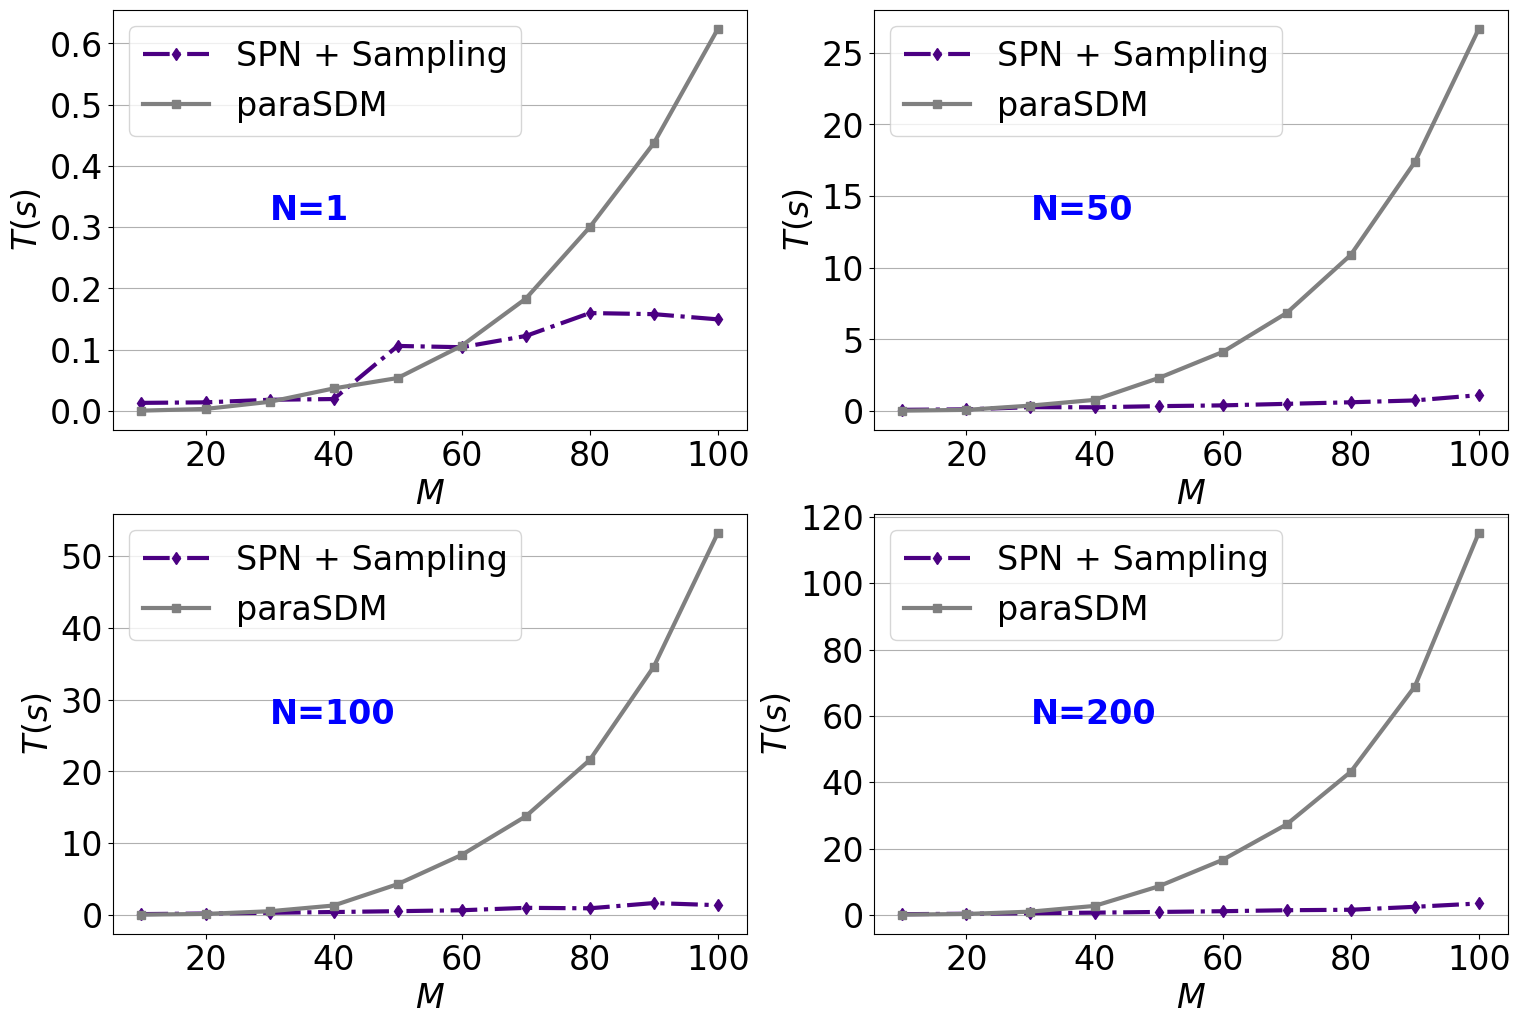

In [68]:
color1 = 'indigo'
color2 = 'gray'
color3 = 'orange'
linestyle1 = '-.'
linestyle2 = '-'
linestyle3 = '--'
fontsize1 = 24
fontsize2 = 24
linewidth1 = 3

plt.figure(figsize=(18,12))
plt.subplot(2,2,1)
plt.plot(num_facilities,times_1_L,linestyle1,marker='d',linewidth=linewidth1,color=color1,label='SPN + Sampling')
plt.plot(num_facilities,times_1_F,linestyle2,marker='s',linewidth=linewidth1,color=color2,label='paraSDM')
plt.xlabel(rf'$M$', fontsize=fontsize1)
plt.ylabel(rf'$T(s)$', fontsize=fontsize1)
plt.text(num_facilities[2],times_1_F[-1]*0.5,"N=1",fontsize=fontsize1,color='blue',weight='bold')
plt.yticks(fontsize=fontsize1)
plt.xticks(fontsize=fontsize1)
plt.grid(axis='y',alpha=1)
plt.legend(fontsize=fontsize1)

plt.subplot(2,2,2)
plt.plot(num_facilities,times_2_L,linestyle1,marker='d',linewidth=linewidth1,color=color1,label='SPN + Sampling')
plt.plot(num_facilities,times_2_F,linestyle2,marker='s',linewidth=linewidth1,color=color2,label='paraSDM')
plt.xlabel(rf'$M$', fontsize=fontsize1)
plt.ylabel(rf'$T(s)$', fontsize=fontsize1)
plt.text(num_facilities[2],times_2_F[-1]*0.5,"N=50",fontsize=fontsize1,color='blue',weight='bold')
plt.yticks(fontsize=fontsize1)
plt.xticks(fontsize=fontsize1)
plt.grid(axis='y',alpha=1)
plt.legend(fontsize=fontsize1)

plt.subplot(2,2,3)
plt.plot(num_facilities,times_3_L,linestyle1,marker='d',linewidth=linewidth1,color=color1,label='SPN + Sampling')
plt.plot(num_facilities,times_3_F,linestyle2,marker='s',linewidth=linewidth1,color=color2,label='paraSDM')
plt.xlabel(rf'$M$', fontsize=fontsize1)
plt.ylabel(rf'$T(s)$', fontsize=fontsize1)
plt.text(num_facilities[2],times_3_F[-1]*0.5,"N=100",fontsize=fontsize1,color='blue',weight='bold')
plt.yticks(fontsize=fontsize1)
plt.xticks(fontsize=fontsize1)
plt.grid(axis='y',alpha=1)
plt.legend(fontsize=fontsize1)

plt.subplot(2,2,4)
plt.plot(num_facilities,times_4_L,linestyle1,marker='d',linewidth=linewidth1,color=color1,label='SPN + Sampling')
plt.plot(num_facilities,times_4_F,linestyle2,marker='s',linewidth=linewidth1,color=color2,label='paraSDM')
plt.xlabel(rf'$M$', fontsize=fontsize1)
plt.ylabel(rf'$T(s)$', fontsize=fontsize1)
plt.text(num_facilities[2],times_4_F[-1]*0.5,"N=200",fontsize=fontsize1,color='blue',weight='bold')
plt.yticks(fontsize=fontsize1)
plt.xticks(fontsize=fontsize1)
plt.grid(axis='y',alpha=1)
plt.legend(fontsize=fontsize1)

# plt.figure(figsize=(16,3))
# plt.plot(num_facilities,grad_norm_error_1,linestyle1,marker='v',color=color1,label='grad_norm_error')
# plt.xlabel('Num F')
# # plt.ylabel('')
# plt.title('N_drones = 1')
# # plt.yticks(np.linspace(0,35,15))
# plt.grid(axis='y',alpha=1)
# plt.legend()

plt.show()

In [11]:
# times_1_F=[]
# times_2_F=[]
# times_3_F=[]
# times_4_F=[]
# torch.cuda.empty_cache()
# for data in tqdm(Data_1):
#     s = time.time()
#     with torch.no_grad():
#         generate_true_labels(data,10)
#     times_1_F.append(time.time()-s)
#     torch.cuda.empty_cache()
# for data in tqdm(Data_2):
#     s = time.time()
#     with torch.no_grad():
#         generate_true_labels(data,10)
#     times_2_F.append(time.time()-s)
#     torch.cuda.empty_cache()
# for data in tqdm(Data_3):
#     s = time.time()
#     with torch.no_grad():
#         generate_true_labels(data,10)
#     times_3_F.append(time.time()-s)
#     torch.cuda.empty_cache()
# for data in tqdm(Data_4):
#     s = time.time()
#     with torch.no_grad():
#         generate_true_labels(data,10)
#     times_4_F.append(time.time()-s)
#     torch.cuda.empty_cache()

In [8]:
times_1_G=[]
times_2_G=[]
times_3_G=[]
times_4_G=[]
torch.cuda.empty_cache()
for data in tqdm(Data_1):
    s = time.time()
    with torch.no_grad():
        generate_true_labels1(data,10)
    times_1_G.append(time.time()-s)
    torch.cuda.empty_cache()
for data in tqdm(Data_2):
    s = time.time()
    with torch.no_grad():
        generate_true_labels1(data,10)
    times_2_G.append(time.time()-s)
    torch.cuda.empty_cache()
for data in tqdm(Data_3):
    s = time.time()
    with torch.no_grad():
        generate_true_labels1(data,10)
    times_3_G.append(time.time()-s)
    torch.cuda.empty_cache()
for data in tqdm(Data_4):
    s = time.time()
    with torch.no_grad():
        generate_true_labels1(data,10)
    times_4_G.append(time.time()-s)
    torch.cuda.empty_cache()

100%|██████████| 20/20 [24:26<00:00, 73.32s/it] 


# Save the data

In [ ]:
# import pickle

# action_runtime_data = {}

# action_runtime_data['times_1_L'] = times_1_L
# action_runtime_data['times_2_L'] = times_2_L
# action_runtime_data['times_3_L'] = times_3_L
# action_runtime_data['times_4_L'] = times_4_L

# action_runtime_data['times_1_F'] = times_1_F
# action_runtime_data['times_2_F'] = times_2_F
# action_runtime_data['times_3_F'] = times_3_F
# action_runtime_data['times_4_F'] = times_4_F

# action_runtime_data['times_1_G'] = times_1_G
# action_runtime_data['times_2_G'] = times_2_G
# action_runtime_data['times_3_G'] = times_3_G
# action_runtime_data['times_4_G'] = times_4_G

# filename = 'action_runtime_data.pkl'
# with open(filename, 'wb') as file:
#     pickle.dump(action_runtime_data, file)


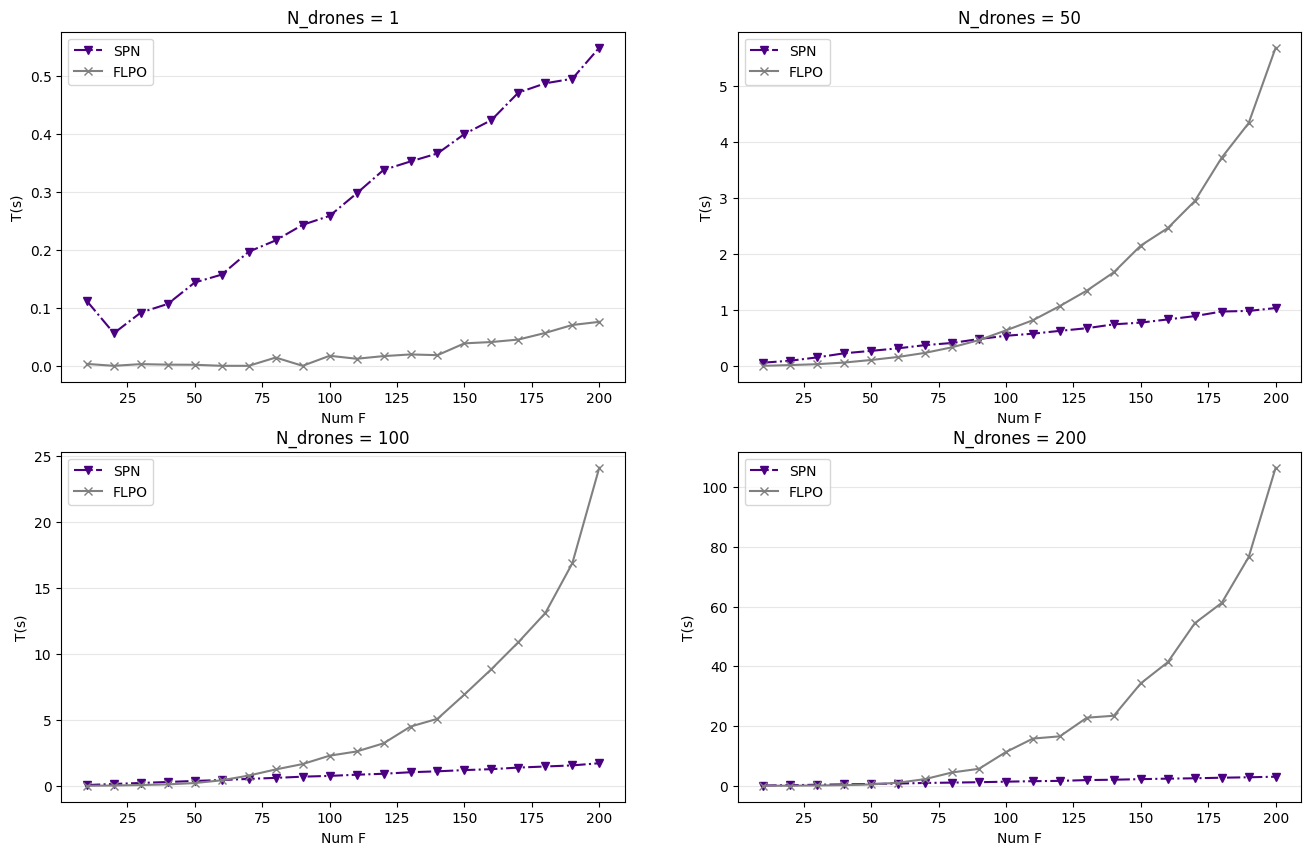

In [7]:
color1 = 'indigo'
color2 = 'gray'
color3 = 'orange'
linestyle1 = '-.'
linestyle2 = '-'
linestyle3 = '--'

plt.figure(figsize=(16,10))

plt.subplot(2,2,1)
plt.plot(num_facilities,times_1_L,linestyle1,marker='v',color=color1,label='SPN')
plt.plot(num_facilities,times_1_F,linestyle2,marker='x',color=color2,label='FLPO')
# plt.plot(num_facilities,times_1_G,linestyle3,marker='o',color=color3,label='FLPO_DP_1')
# plt.yscale('log')
plt.xlabel('Num F')
plt.ylabel('T(s)')
plt.title('N_drones = 1')
# plt.yticks(np.linspace(0,35,15))
plt.grid(axis='y',alpha=0.3)
plt.legend()

plt.subplot(2,2,2)
plt.plot(num_facilities,times_2_L,linestyle1,marker='v',color=color1,label='SPN')
plt.plot(num_facilities,times_2_F,linestyle2,marker='x',color=color2,label='FLPO')
# plt.plot(num_facilities,times_2_G,linestyle3,marker='o',color=color3,label='FLPO_DP')
# plt.yscale('log')
plt.xlabel('Num F')
plt.ylabel('T(s)')
plt.title('N_drones = 50')
# plt.yticks(np.linspace(0,35,15))
plt.grid(axis='y',alpha=0.3)
plt.legend()

plt.subplot(2,2,3)
plt.plot(num_facilities,times_3_L,linestyle1,marker='v',color=color1,label='SPN')
plt.plot(num_facilities,times_3_F,linestyle2,marker='x',color=color2,label='FLPO')
# plt.plot(num_facilities,times_3_G,linestyle3,marker='o',color=color3,label='FLPO_DP')
# plt.yscale('log')
plt.xlabel('Num F')
plt.ylabel('T(s)')
plt.title('N_drones = 100')
# plt.yticks(np.linspace(0,35,15))
plt.grid(axis='y',alpha=0.3)
plt.legend()

plt.subplot(2,2,4)
plt.plot(num_facilities,times_4_L,linestyle1,marker='v',color=color1,label='SPN')
plt.plot(num_facilities,times_4_F,linestyle2,marker='x',color=color2,label='FLPO')
# plt.plot(num_facilities,times_4_G,linestyle3,marker='o',color=color3,label='FLPO_DP')
# plt.yscale('log')
plt.xlabel('Num F')
plt.ylabel('T(s)')
plt.title('N_drones = 200')
# plt.yticks(np.linspace(0,35,15))
plt.grid(axis='y',alpha=0.3)
plt.legend()


# plt.plot(num_facilities,times_1_L,linestyle1,marker='v',color=color1,label='SPN_1')
# plt.plot(num_facilities,times_2_L,linestyle1,marker='o',color=color1,label='SPN_50')
# plt.plot(num_facilities,times_3_L,linestyle1,marker='^',color=color1,label='SPN_100')
# plt.plot(num_facilities,times_4_L,linestyle1,marker='x',color=color1,label='SPN_200')

# plt.plot(num_facilities,times_1_F,linestyle2,marker='v',color=color2,label='FLPO_1')
# plt.plot(num_facilities,times_2_F,linestyle2,marker='o',color=color2,label='FLPO_50')
# plt.plot(num_facilities,times_3_F,linestyle2,marker='^',color=color2,label='FLPO_100')
# plt.plot(num_facilities,times_4_F,linestyle2,marker='x',color=color2,label='FLPO_200')

# plt.plot(num_facilities,times_1_G,linestyle3,marker='v',color=color3,label='FLPO_DP_1')
# plt.plot(num_facilities,times_2_G,linestyle3,marker='o',color=color3,label='FLPO_DP_50')
# plt.plot(num_facilities,times_3_G,linestyle3,marker='^',color=color3,label='FLPO_DP_100')
# plt.plot(num_facilities,times_4_F,linestyle3,marker='x',color=color3,label='FLPO_DP_200')

# plt.legend()
# plt.title('GPU Runtime Comparison (Total Route)')
plt.savefig("SpeedTestResults.svg")

plt.show()
